# Introduction

In this notebook, I will extract restaurant ratings and reviews from [Foursquare](https://foursquare.com/), and use distance (one of the main ideas behind recommender systems) to generate recommendations for restaurants in one city that have similar reviews to restaurants in another city.

### Motivation

I grew up in Austin, Texas, but moved to Minneapolis, Minnesota for my wife's work.  Being people who love food, we had to find new restaurants to replace our favorites from back home.  However, most decently rated places we went to were...lacking.  They came at the recommendations of coworkers,  neighbors, or from Google ratings, but the food was often bland and overpriced.  It took us one look at the actual reviews to figure it out.  

In order to better illustrate our problem, here are recent reviews from three places we tried that we were disappointed in.  On the left is a pizza shop, the middle is a typical American restaurant, and the right is a Vietnamese restaurant:

<img style="float: left; width: 250px;" src="http://i.imgur.com/XZ00nBV.png">

<img style="float: right; width: 250px;" src="http://i.imgur.com/9C8c1ql.png">

<img style="float: none!important; display: block; width: 250px;" src="http://i.imgur.com/D15CLBU.png">

The font may be too small to read, but I highlighted the main points.  Service, atmosphere, and apparently eggrolls were the common factors.  You don't see a lot of mentions of how good the actual food is, and you can even see an instance of someone rating the pizza place as 5/5 even after saying that it is pricey.  So, obviously, there is a disconnect in how I evaluate restaurants versus how the people of Minneapolis evaluate restaurants.  If you have previously worked with recommender systems, you already know where I'm going with this.  If not, here is a primer:

### Recommender Systems Overview

Before getting into the overview of recommender systems, I wanted to point out that I won't actually be building a legitimate recommender system in this notebook.  There are some [great](https://turi.com/learn/userguide/recommender/introduction.html) [packages](https://github.com/lyst/lightfm) for doing so, but I'm going to stick with one of the main ideas behind recommender systems.  This is for two reasons:

**1)** Classes have started back up, and my available free time for side projects like this one has mostly dried up

**2)** My gastronomic adventures don't need the added benefits that a recommender system provides over what I'll be doing

If you're still interested after that, let's get back into it.

In the world of recommender systems, there are three broad types:

- **[Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)**: The most prevalent type - uses "wisdom of the crowd" for popularity among peers.  This is so popular because you don't need to know a lot about the item itself, you only need the ratings on it from people.  The two restrictions are that it has the assumption that peoples tastes do not change, and new items run into the "cold start problem".  This is when it has not yet received any ratings, and fails to appear on recommendation lists.
    - People who like item X also like item Y
    - This is how Spotify selects songs for your recommended playlist.  Specifically, it will take songs from other playlists that contain songs you recently liked.
    
    
- **[Content-Based](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)**: Recommends items based off of their similarity.  This requires reliable information about the items themselves, which makes it difficult to implement in a lot of areas.  Additionally, recommendations generated from this will likely not deviate very far from the item being compared to, but there are tricks available to account for this.  This is similar to how Pandora's model for selecting songs on a station.
    - Item X is similar to item Y
    - This is how Pandora selects songs for your stations.  Specifically, it assigns each song a list of characteristics (assigned through the [Music Genome Project](http://www.pandora.com/corporate/mgp.shtml)), and selects songs with similar characteristics as those that you liked.
    

- **[Hybrid](https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems)**: You probably guessed it - this is a combination of the above two.  The idea here is use what you have if you have it.  There are a few designs of this [worth looking into](http://www.math.uci.edu/icamp/courses/math77b/lecture_12w/pdfs/Chapter%2005%20-%20Hybrid%20recommendation%20approaches.pdf).


Those are the three main types, but there is one other type that you may find if you are reading more:


- **[Knowledge-Based](https://en.wikipedia.org/wiki/Knowledge-based_recommender_system)**: This is the most rare type due to requiring explicit domain knowledge.  This is often used for products that have a low number of available ratings, such as high luxury goods like hypercars.  We won't delve any further into this type, but I recommend reading more about them if you're interested.


### Method

Going back to our problem, the previous way of selecting restaurants at the recommendation of our coworkers and neighbors (collaborative filtering) failed, so we are going to used the idea behind content-based recommender systems.  However, we don't have a lot of content about the restaurants, so we are going to use the reviews people left for them.  More specifically, we are going to determine similarity between restaurants based off of the reviews that people write for them.  

We're going to use cosine similarity since it's generally accepted as producing better results in item-to-item filtering.  Specifically,

$sim(A, B) = \cos(\theta) = \frac{A \cdot B}{\|A\|\|B\|}$

Before calculating this, we need to perform a couple of pre-processing steps on our reviews in order to make it more useable for our cosine similarity calculation.  These will be common NLP (**n**atural **l**anguage **p**rocessing) techniques that you should be familiar with if you have worked with text before.  There are likely better ways to go about the text processing for this problem (and please let me know if you believe there are so I can update this when I have time), but here are the steps I will be taking:

**1) Tokenizing**: This breaks up a sentence into individual words.  This is basically turning our reviews into [bags of words](https://en.wikipedia.org/wiki/Bag-of-words_model), which makes it easier to perform other operations.
- Ex. 'Central Texas barbecue is the best smoked and the only barbecue that matters' becomes
    - ['Central', 'Texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters']

**2) Sentiment Analysis**: While not a pre-processing technique, it will be a useful to include when determining similarity. There are a few reasons to this **[go into why, and why doing it here, and examples]**

**3) Normalizing**: This just means converting our tokens into lower case.  Like tokenizing, this makes it play nicely with other operations.
- Ex. ['Central', 'Texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters'] becomes 
    - ['central', 'texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters']

**4) Removing Stopwords and Punctuation**: Takes out unnecessary words and punctuation that we use in language that computers don't care about such as *as*, *the*, *and*, and *of*
- Ex. ['central', 'texas', 'barbecue', 'is', 'the', 'best', 'smoked', 'and', 'the', 'only', 'barbecue', 'that', 'matters'] becomes 
    - ['central', 'texas', 'barbecue', 'best', 'smoked', 'only', 'barbecue', 'matters']

**5) Stemming**: Removes variations at the end of a word to revert words to their root
- Ex. ['central', 'texas', 'barbecue', 'best', 'smoked', 'only', 'barbecue', 'matters'] becomes
    - ['central', 'texas', 'barbecue', 'best', 'smoke', 'only', 'barbecue', 'matter']

**6) Term Frequency-Inverse Document Frequency (TF-IDF)**: Determines how important a word is to a document (which is a review in this case) within a corpus (the collection documents).  This doesn't necessarily help establish context within our reviews themselves (for example, 'this Pad Kee Mao is bad ass' is technically a good thing, but it wouldn't be accounted for unless we did [n-grams](https://en.wikipedia.org/wiki/N-gram) (which will give my laptop a much more difficult time)), but it does help with establishing the importance of the word.

$t$: Term

$d$: Document

$TFIDF(t, d) = TF(t, d) \cdot IDF(t)$

$IDF(t) =  1 + \log(\frac{\#\ Documents}{\#\ Documents\ Containing\ t})$

There are a lot of areas in NLP that cause difficulties that we will be ignoring due to the nature of our problem. Sarcasm, slang, misspellings, and context are common problems in NLP, but we will be ignoring these due to the limitation on time.  

### Assumptions

It's always important to state your assumptions in any analysis because a violation of them will often render the results unreliable.

- The reviews are indicative of the characteristics of the restaurant
- The language used in the reviews does not directly impact the rating
     - E.g. Reviews contain a description of their experience, but ratings are the result of the user applying weights to specific things they value
     - Ex. "The food was great, but the service was terrible." would be a 2/10 for one user, but a 7/10 for users like myself
- The restaurants did not undergo significant changes in the time frame for the reviews being pulled
- Sarcasm, slang, misspellings, and other common NLP problems will not have a significant impact on our results

---
# Restaurant Recommender


If you're still with us after all of that, let's get started!

---

In addition to the library imports, we have to specify our credentials to access the foursquare API.  I'm not keen on sharing mine (sorry, but not really), but you can get your own by [signing up](https://developer.foursquare.com/).  I stored mine in a text file which is being read in.

In [78]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler, normalize

import foursquare

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")  # Setting plotting style

%matplotlib inline

In [2]:
# Reading credentials for the API
with open('foursquareCredentials.txt') as f:
    lines = [line.split('=')[1] for line in f.readlines()]
    credentials = [line.replace("'", '').replace('\n', '') for line in lines]
    f.close()

# Assigning the credentials to an object
client = foursquare.Foursquare(
    client_id=credentials[0], 
    client_secret=credentials[1], 
    redirect_uri=credentials[2])

## The Data

Foursquare works similarly to Yelp where users will review restaurants.  They can either leave a rating (1-10), or write a comment for the restaurant.  The comment is what we're interested in here since I established above that the rating has less meaning due to the way people rate restaurants differently between the two cities.

The [documentation](https://developer.foursquare.com/docs/) was fortunately fairly robust.  I used the [foursquare categoryID tree](https://developer.foursquare.com/categorytree) in order to grab the venue category ID for the different types of restaurants.  The [venue search](https://developer.foursquare.com/docs/venues/search) function grabs the actual restaurants, and the [tips](https://developer.foursquare.com/docs/venues/tips) function returns the comments (and not what users left for a tip like you'd think).

We're going to use the individual comments, restaurant category, price tier, and the number of check-ins, comments, and users.


### Restaurants

Before pulling our restaurants, we have to first include a few parameters.  We'll begin with the cities we want to include and the restaurant types we want to include.

Since we're not interested in chains or fast food places, we have to specify which venue category IDs we want.  There are also a few grocery stores (such as Whole Foods and the magnificent [H-E-B](https://www.heb.com/)) that appear under the bakery and deli categories, so excluding this is easier than manually filtering them out.  I left them commented out so there is the full list in case anyone else would like to include them for their own uses.

In [3]:
cities = ['Austin, TX',  # Where I'm from
          'Minneapolis, MN']  # Where I'm going to grad school  

venueCategoryId = ['503288ae91d4c4b30a586d67'  # Afghan
                       , '4bf58dd8d48988d1c8941735'  # African
                       , '4bf58dd8d48988d14e941735'  # American
                       , '4bf58dd8d48988d142941735'  # Asian.  Includes most Asian countries.
                       , '4bf58dd8d48988d169941735'  # Australian
                       , '52e81612bcbc57f1066b7a01'  # Austrian
                       , '4bf58dd8d48988d1df931735'  # BBQ
                       , '4bf58dd8d48988d179941735'  # Bagel
#                        , '4bf58dd8d48988d16a941735'  # Bakery
                       , '52e81612bcbc57f1066b7a02'  # Belgian
                       , '52e81612bcbc57f1066b79f1'  # Bistro
                       , '4bf58dd8d48988d143941735'  # Breakfast
                       , '52e81612bcbc57f1066b7a0c'  # Bubble Tea
                       , '4bf58dd8d48988d16c941735'  # Burgers.  Does not include fast food.
                       , '4bf58dd8d48988d16d941735'  # Cafe
                       , '4bf58dd8d48988d17a941735'  # Cajun/Creole
                       , '4bf58dd8d48988d144941735'  # Caribbean
                       , '5293a7d53cf9994f4e043a45'  # Caucasian
                       , '4bf58dd8d48988d1e0931735'  # Coffee Shop
                       , '52e81612bcbc57f1066b7a00'  # Comfort Food
                       , '52e81612bcbc57f1066b79f2'  # Creperie
                       , '52f2ae52bcbc57f1066b8b81'  # Czech
#                        , '4bf58dd8d48988d146941735'  # Deli
                       , '4bf58dd8d48988d1d0941735'  # Dessert
                       , '4bf58dd8d48988d147941735'  # Diner
                       , '4bf58dd8d48988d148941735'  # Donuts
                       , '5744ccdfe4b0c0459246b4d0'  # Dutch
                       , '4bf58dd8d48988d109941735'  # Eastern Europe
                       , '52e81612bcbc57f1066b7a05'  # English
                       , '4bf58dd8d48988d10b941735'  # Falafel
                       , '4edd64a0c7ddd24ca188df1a'  # Fish & Chips
                       , '52e81612bcbc57f1066b7a09'  # Fondue
                       , '56aa371be4b08b9a8d57350b'  # Food Stand
                       , '4bf58dd8d48988d1cb941735'  # Food Truck
                       , '4bf58dd8d48988d10c941735'  # French
                       , '4bf58dd8d48988d155941735'  # Gastropub
                       , '4bf58dd8d48988d10d941735'  # German
                       , '4bf58dd8d48988d10e941735'  # Greek
                       , '52e81612bcbc57f1066b79ff'  # Halal
                       , '52e81612bcbc57f1066b79fe'  # Hawaiian
                       , '52e81612bcbc57f1066b79fa'  # Hungarian
                       , '4bf58dd8d48988d10f941735'  # Indian
                       , '52e81612bcbc57f1066b7a06'  # Irish Pub
                       , '4bf58dd8d48988d110941735'  # Italian
                       , '52e81612bcbc57f1066b79fd'  # Jewish
                       , '4bf58dd8d48988d112941735'  # Juice Bar
                       , '5283c7b4e4b094cb91ec88d7'  # Kebab
                       , '4bf58dd8d48988d1be941735'  # Latin American
                       , '4bf58dd8d48988d1c0941735'  # Mediterranean
                       , '4bf58dd8d48988d1c1941735'  # Mexican
                       , '4bf58dd8d48988d115941735'  # Middle Eastern
                       , '52e81612bcbc57f1066b79f9'  # Modern European
                       , '52e81612bcbc57f1066b79f8'  # Pakistani
                       , '56aa371be4b08b9a8d573508'  # Pet Cafe
                       , '4bf58dd8d48988d1ca941735'  # Pizza
                       , '52e81612bcbc57f1066b7a04'  # Polish
                       , '4def73e84765ae376e57713a'  # Portuguese
                       , '5293a7563cf9994f4e043a44'  # Russian
                       , '4bf58dd8d48988d1bd941735'  # Salad
                       , '4bf58dd8d48988d1c6941735'  # Scandinavian
                       , '5744ccdde4b0c0459246b4a3'  # Scottish
                       , '4bf58dd8d48988d1ce941735'  # Seafood
                       , '56aa371be4b08b9a8d57355a'  # Slovak
                       , '4bf58dd8d48988d1dd931735'  # Soup
                       , '4bf58dd8d48988d14f941735'  # Southern
                       , '4bf58dd8d48988d150941735'  # Spanish
                       , '5413605de4b0ae91d18581a9'  # Sri Lankan
                       , '4bf58dd8d48988d1cc941735'  # Steakhouse
                       , '4bf58dd8d48988d158941735'  # Swiss
                       , '4bf58dd8d48988d1dc931735'  # Tea Room
                       , '56aa371be4b08b9a8d573538'  # Theme Restaurant
                       , '4f04af1f2fb6e1c99f3db0bb'  # Turkish
                       , '52e928d0bcbc57f1066b7e96'  # Ukranian
                       , '4bf58dd8d48988d1d3941735'  # Vegetarian
                      ]
venueCategoryIdstr = ','.join(venueCategoryId)  # Converts to string for API call

With those specified, we'll go ahead and pull in the restaurants.  This loop will go through each restaurant category, grab the restaurants that meet our criteria, and puts them into a data frame called dfRest (**d**ata **f**rame of **rest**aurants).

Tasks like these can sometimes take a lot of time, but this fortunately runs in under a minute.

In [4]:
%%time

# Empty data frame to be filled with restaurant information
dfRest = pd.DataFrame()

for city in cities:
    
    # Run the API for each category
    for category in venueCategoryId:
        apiCall = client.venues.search(params = 
                        {'near': city
                        , 'intent': 'browse'  # Non-user based
                        , 'limit': '50'  # Max is 50
                        , 'radius': '56372'  # In meters.  Converts to 35 miles
                        , 'categoryId': category})['venues']
        if len(apiCall) == 0:
            pass
        else:
            for restaurant in np.arange(len(apiCall)):
                
                # Error handling due to not every restaurant possessing
                # a value for city/state
                try:
                    apiCity = apiCall[restaurant]['location']['city']
                    apiState = apiCall[restaurant]['location']['state']
                except:
                    apiCity = np.NaN
                    apiState = np.NaN
                
                # Appending a temporary data frame to dfRest to prevent overwriting
                temp = pd.DataFrame({
                        'name': apiCall[restaurant]['name'],
                        'id': apiCall[restaurant]['id'],
                        'category': apiCall[restaurant]['categories'][0]['name'],
                        'shortCategory': apiCall[restaurant]['categories'][0]['shortName'],
                        'city': apiCity,
                        'state': apiState,
                        'location': city,
                        'checkinsCount': apiCall[restaurant]['stats']['checkinsCount'],
                        'commentsCount': apiCall[restaurant]['stats']['tipCount'],
                        'usersCount': apiCall[restaurant]['stats']['usersCount']
                    }, index=[0])
                dfRest = pd.concat([dfRest, temp])

Wall time: 52.8 s


In [5]:
dfRest.shape

(3050, 10)

Now that we have pulled the restaurants, let's clean it up by removing any restaurants with:
- **Duplicates:** A small handful of these sneaked through, and we only need one of each
- **$<$ 10 comments:** These won't be too useful for our purposes
- **Categories we don't want:** Some of these also got through, and I have no interest in seeing how the Burger King around the corner compares to a Whataburger back home

In [6]:
# Cleaning the dataset before making more API calls
dfRest = dfRest.dropna().drop_duplicates()
dfRest = dfRest[dfRest['commentsCount'] >= 10]

# Removing unwanted categories
excludeCategories = ['Fast Food', 'Gas Station', 'Golf Course', 'Bowling Alley']
dfRest = dfRest.loc[~dfRest.category.isin(excludeCategories)]

In [10]:
dfRest.shape

(1365, 10)

While that removed more than half of our records, ~1,300 restaurants is still plenty enough to work with.  This will also drastically reduce the number of comments we need to grab, as well.

Moving on, let's look at a few charts for exploratory analysis to see what restaurants we ended up with:

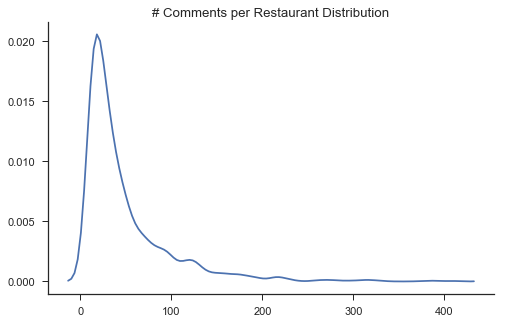

In [69]:
plt.figure(figsize=(8, 5))
sns.kdeplot(dfRest['commentsCount'], legend=False)
plt.title('# Comments per Restaurant Distribution')
sns.despine()

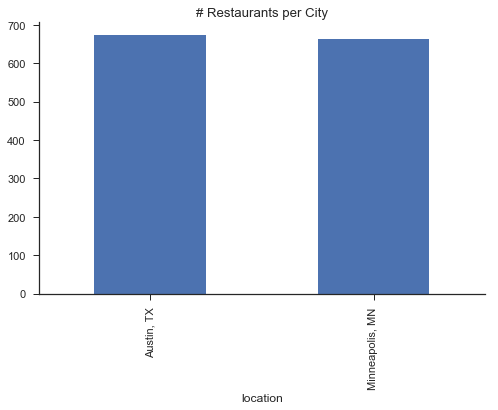

In [71]:
plt.figure(figsize=(8, 5))
dfRest['id'].groupby(dfRest['location']).count().plot(kind='bar')
plt.title('# Restaurants per City')
sns.despine()

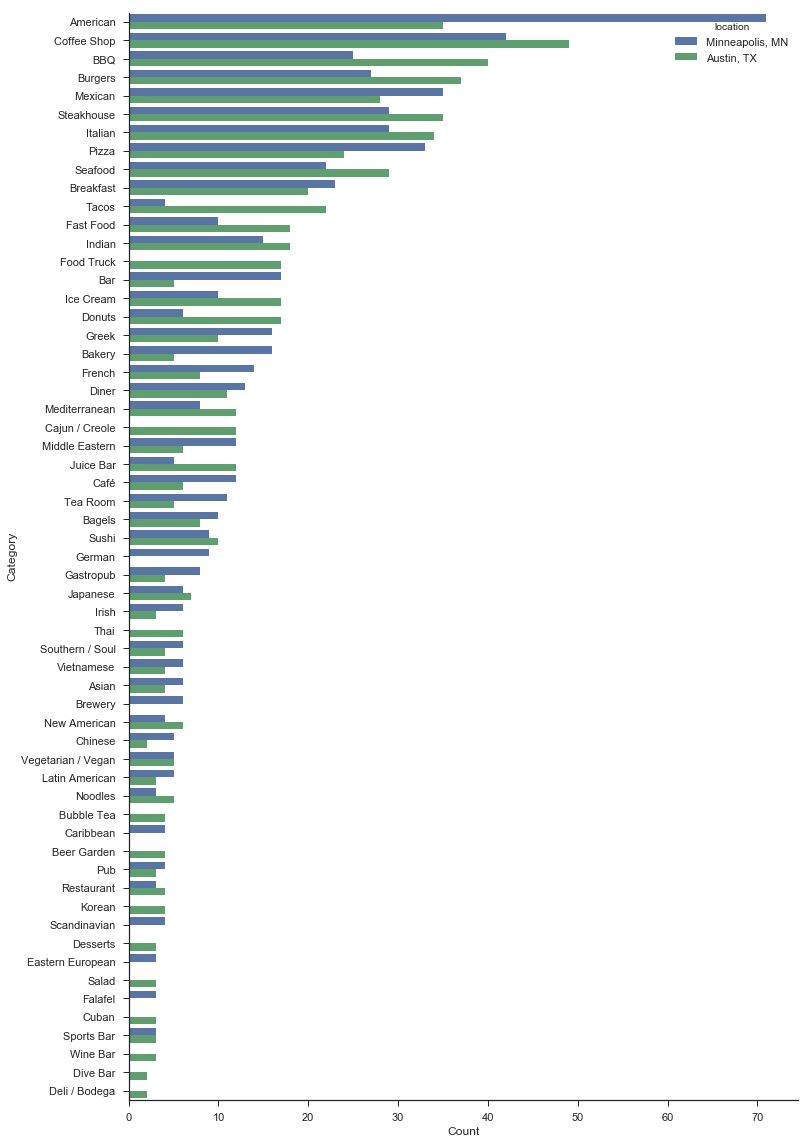

In [76]:
plt.figure(figsize=(12, 20))

# Grouping by the number of restaurants per category and city
categoryPlot = dfRest['id'].groupby(
    (dfRest['shortCategory'], dfRest['location'])).count().sort_values(
        ascending=False)[:100].reset_index()

# Plotting 
sns.barplot(x="id", y="shortCategory", hue="location", data=categoryPlot)

# Setting labels and configuring visuals
plt.xlabel('Count')
plt.ylabel('Category')
sns.despine()

So our number of restaurants between each city is basically even, most restaurants have between 10 and 70 comments, and we see a few interesting things in the breakdown between categories.  To summarize the chart:

**Austin:**
- Significantly more BBQ, tacos, food trucks, donuts, juice bars, and Cajun restaurants (but I could have told you this)
- Seemingly more diversity in the smaller categories

**Minneapolis:**
- American is king
- Significantly more bars, bakeries, middle eastern, cafes, tea rooms, German, and breweries
- More Mexican places?  That doesn't entirely sound right, but it's not a drastic difference

Our initial pull didn't include the ratings, so we'll go ahead and pull those in along with the price tier.

This loop takes a lot longer (~7 minutes), possibly due to making individual calls for each restaurant (~1,300) instead of just each category (~72).

In [29]:
%%time

ratings = []
numRatings = []
priceTiers = []

for restId in dfRest['id']:
    apiCall = client.venues(restId)['venue']
    
    try:
        rate = apiCall['rating']
        numRates = apiCall['ratingSignals']
        tiers = apiCall['attributes']['groups'][0]['items'][0]['priceTier']
    except:
        rate = np.NaN
        numRates = np.NaN
        tiers = np.NaN
        
    ratings.append(rate)
    numRatings.append(numRates)
    priceTiers.append(tiers)
    
dfRest['rating'] = ratings
dfRest['numRatings'] = numRatings
dfRest['priceTier'] = priceTiers

Wall time: 6min 17s


In [30]:
# Re-ordering the columns since the loop puts them out of order
dfRest = dfRest.reindex_axis(
    [
        'id', 'name', 'category', 'shortCategory', 'checkinsCount', 'city',
        'state', 'location', 'commentsCount', 'usersCount', 'priceTier',
        'numRatings', 'rating'
    ],
    axis=1).reset_index(drop=True)

In [31]:
# Cleaning the dataset by dropping duplicates
dfRest = dfRest.dropna().drop_duplicates()

dfRest.head()

,id,name,category,shortCategory,checkinsCount,city,state,location,commentsCount,usersCount,priceTier,numRatings,rating
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1769,Austin,TX,"Austin, TX",17,683,1.0,41.0,6.9
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1463,Austin,TX,"Austin, TX",34,1018,2.0,93.0,8.0
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1047,Pflugerville,TX,"Austin, TX",31,672,2.0,88.0,8.3
3,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,2.0,10.0,6.2
4,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,1.0,15.0,8.0


In [14]:
# Uncomment to save the results if needed
# dfRest.to_csv('dfRest.csv')

### Comments

These are the actual comments people write about the restaurants, and they are what we will be comparing for our "recommender" system.  

This loop grabs the actual comments per restaurant, and puts the comments into the data frame dfComments.  It takes ~10 minutes to run.

Since I'm using a free developer key, I'm currently limited to 30 comments per restaurant ID.  This will impact the quality for some restaurants, but we saw that most of our restaurants had under 30 comments in the earlier chart.

In [77]:
%%time

dfComments = pd.DataFrame()

for rest in dfRest['id']:
    apiCall = client.venues.tips(rest)['tips']['items']
    numComments = len(apiCall)
    
    for idx in np.arange(numComments):
        temp = pd.DataFrame({
                'id': rest,
                'comment': apiCall[idx]['text']
            }, index=[0])
        dfComments = pd.concat([dfComments, temp])
        
dfComments = dfComments.reindex_axis(['id','comment'], axis = 1).reset_index(drop=True)

Wall time: 9min 18s


In [79]:
dfComments.head()

,id,comment
0,4e17b348b0fb8567c665ddaf,"Healthy fresh salad plus baked potatoes, selec..."
1,4e17b348b0fb8567c665ddaf,Make sure to print out your coupons. These fol...
2,4e17b348b0fb8567c665ddaf,"First of all, this place uses CANNED chick pea..."
3,4e17b348b0fb8567c665ddaf,"Great healthy food, good prices. Try the ginge..."
4,4e17b348b0fb8567c665ddaf,Love coming here. Makes getting lunch so easy ...


In [19]:
dfComments.head()

,id,comment,comment_without_num,comments
0,4aceefb7f964a52013d220e3,The lunch buffet is wonderful; everything is f...,the lunch buffet is wonderful; everything is f...,the lunch buffet is wonderful; everything is f...
1,4aceefb7f964a52013d220e3,"Its a small quiet place, you could easily miss...","its a small quiet place, you could easily miss...","itssmall quiet place, you could easily miss it..."
2,4aceefb7f964a52013d220e3,"For a vegan meal, order 4 items from the veget...","for a vegan meal, order items from the vegeta...","forvegan meal, order items from the vegetaria..."
3,4aceefb7f964a52013d220e3,"One of my places to get what I call ""comfort f...","one of my places to get what i call ""comfort f...","one of my places to get whatcall ""comfort food..."
4,4aceefb7f964a52013d220e3,It's not a fancy restaurant but the people are...,it's not a fancy restaurant but the people are...,it's notfancy restaurant but the people are gr...


#### Grouping multiple comments per restaurant together

In [20]:
# Calculating the number of comments per restaurant and merging it to dfRest
commentCounts = dfComments[['comment']].groupby(dfComments['id']).count().reset_index()
commentCounts.columns = ['id', 'commentCount']

dfRest = dfRest.merge(commentCounts, how = 'left', on = 'id')

In [21]:
groupedComments = dfComments.groupby('id')['comments'].apply(
    lambda x: "{%s}" % ''.join(x)).reset_index()

In [22]:
df = pd.merge(dfRest, groupedComments, on='id')

df['comments'] = df['comments'].apply(
    lambda comment: re.sub(r'[^\x00-\x7f]', r'', comment))

df.head()

,id,name,category,shortCategory,checkinsCount,city,state,location,commentsCount,usersCount,priceTier,numRatings,rating,commentCount,comments
0,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1458,Austin,TX,"Austin, TX",34,1016,2.0,93.0,8.3,34,{the lunch buffet is wonderful; everything is ...
1,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1753,Austin,TX,"Austin, TX",17,677,1.0,41.0,6.8,17,"{healthy fresh salad plus baked potatoes, sele..."
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1042,Pflugerville,TX,"Austin, TX",31,668,2.0,89.0,8.3,31,"{wonderful! spicy lovers: kitfo, was awesome! ..."
3,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,1.0,15.0,8.0,11,{west african fusion reigns at this darling tr...
4,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,2.0,10.0,6.3,12,{obsessed with this place one little nugget (...


In [23]:
# df.index = df.id
# df.drop('id', axis=1, inplace=True)

# df.to_csv('dfRestaurant.csv', sep='|')

## Data Processing

When working with language, we have to process the text into something that a computer can handle easier.  Our end result will be a large number of numerical features for each restaurant that we can calculate the cosine similarity on.

The steps here are:
1. Normalizing (lower-casing) all words
2. Removing digits
3. Generating tokens
4. Sentiment Analysis
5. Removing stopwords
6. Stemming
7. TF-IDF

I'll explain a little more on what these are and why we are doing them below in case you aren't familiar with them.

### Normalizing & Removing Digits

This section uses a regex script that makes cases every word lower cased and removes individual digits.

For example:

**Before:**
- "ThIs Is HoW mIdDlE sChOoLeRs TaLkEd 2 EaCh OtHeR oN AIM"

**After:**
- "this is how middle schoolers talked each other on aim"

The benefit in this is that it vastly reduces our feature space.  Our pre-processed example would have created an additional ~10 features from someone who doesn't know how to type like a regular human being.

In [18]:
dfComments['comment_without_num'] = [
    re.sub(r'\d+\S*', '',
           row.lower().replace('.', ' ').replace('_', '').replace('/', ''))
    for row in dfComments['comment']
]

dfComments['comments'] = [
    re.sub(r'(?:^| )\w(?:$| )', '', row)
    for row in dfComments['comment_without_num']
]

### Tokens

In [30]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

df['tokenized_sents'] = df['comments'].apply(tokenizer.tokenize)

df['tokenized_sents'].head()

0    [the, lunch, buffet, is, wonderful, everything...
1    [healthy, fresh, salad, plus, baked, potatoes,...
2    [wonderful, spicy, lovers, kitfo, was, awesome...
3    [west, african, fusion, reigns, at, this, darl...
4    [obsessed, with, this, place, one, little, nug...
Name: tokenized_sents, dtype: object

In [32]:
# df.head()

### Sentiment Analysis

In [26]:
%%time

# from vaderSentiment.vaderSentiment import sentiment as vaderSentiment

# def senti(para):
#     lines_list = tokenize.sent_tokenize(para)
    
#     negList = []
#     neuList = []
#     posList = []
#     compoundList = []
#     for lines in lines_list:
#         negs = vaderSentiment(lines)['neg']
#         negList.append(negs)
#         neu = vaderSentiment(lines)['neu']
#         neuList.append(neu)
#         poss = vaderSentiment(lines)['pos']
#         posList.append(poss)
#         comps = vaderSentiment(lines)['compound']
#         compoundList.append(comps)
        
#     sentiList = [np.array(negList).mean(),np.array(neuList).mean(),np.array(posList).mean(),np.array(compoundList).mean()]
#     return sentiList

# tips['sentiment'] = tips['tip'].apply(lambda x: senti(x.encode('ascii', 'ignore'))[3])
# tips['positivity'] = tips['tip'].apply(lambda x: senti(x.encode('ascii', 'ignore'))[2])
# tips['neutrality'] = tips['tip'].apply(lambda x: senti(x.encode('ascii', 'ignore'))[1])
# tips['negativity'] = tips['tip'].apply(lambda x: senti(x.encode('ascii', 'ignore'))[0])w

Wall time: 0 ns


### Removing Stopwords 

In [33]:
%%time

from nltk.corpus import stopwords

filtered_words = []
for row in df['tokenized_sents']:
    filtered_words.append([word.lower() for word in row if word.lower() not in stopwords.words('english')])

df['filtered_words'] = filtered_words

Wall time: 5min 29s


### Stemming

Talk about why Lemmatizing is better than Porter stemming

In [34]:
%%time

from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

stemmed_words = []
for row in df['filtered_words']:
    stemmed_words.append([lmtzr.lemmatize(word.lower()) for word in row if word.lower() not in stopwords.words('english')]) 
    
df['stemmed_words'] = stemmed_words

Wall time: 3min 21s


In [35]:
allWords = []
nonASCII = []

for row in stemmed_words:
    for word in row:
        try:
            allWords.append(str(word))
        except:
            nonASCII.append(word)

In [36]:
uniqueWords = np.unique(allWords)

In [37]:
print('Number of unique words:,' len(uniqueWords))
print('Preview of the initial unique words:\n', uniqueWords[1:12])

38007
['aaa' 'aaaaaaa' 'aaaaaaamazing' 'aaaaaamaaaaaaazing' 'aaaaand'
 'aaaammaazzing' 'aaallllllll' 'aaand' 'aaarrrggghhh' 'aachar' 'aahhhclaro']


In [38]:
stemmed_sentences = []

for row in df['stemmed_words']:
    stemmed_string = ''
    for word in row:
        stemmed_string = stemmed_string + ' ' + word
    stemmed_sentences.append(stemmed_string)

df['stemmed_sentences'] = stemmed_sentences

### TF-IDF

In [40]:
%%time

import sklearn.feature_extraction.text as sfText

vocabulary = uniqueWords
vect = sfText.CountVectorizer(vocabulary=vocabulary)

vect.fit(uniqueWords)

X = vect.transform(df['stemmed_sentences'][1:5001])

tokenMatrix = pd.DataFrame(X.A, columns=vect.get_feature_names())

Wall time: 1.27 s


In [41]:
tokenMatrix.head()

,aa,aaa,aaaaaaa,aaaaaaamazing,aaaaaamaaaaaaazing,aaaaand,aaaammaazzing,aaallllllll,aaand,aaarrrggghhh,...,zubrodka,zucca,zucchini,zucchinithe,zuccotto,zuchini,zuppa,zur,zushi,zzzzzzzzzzzzpumpkin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
%%time

from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)

tfidf = transformer.fit_transform(tokenMatrix)

tfidfDataFrame = pd.DataFrame(tfidf.toarray())
tfidfDataFrame.columns = tokenMatrix.columns

C:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1037: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


Wall time: 1.76 s


In [43]:
tfidfDataFrame.head()

,aa,aaa,aaaaaaa,aaaaaaamazing,aaaaaamaaaaaaazing,aaaaand,aaaammaazzing,aaallllllll,aaand,aaarrrggghhh,...,zubrodka,zucca,zucchini,zucchinithe,zuccotto,zuchini,zuppa,zur,zushi,zzzzzzzzzzzzpumpkin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


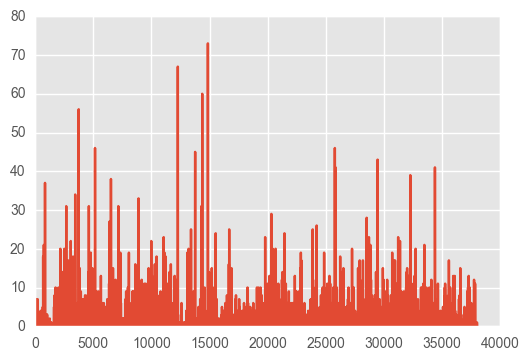

In [44]:
freq = []

for col in tfidfDataFrame:
    freq.append(int(tfidfDataFrame[col].sum()))
    
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(np.array(freq))

plt.show()

In [45]:
redundantCols = []

for row in tfidfDataFrame:
    if tfidfDataFrame[row].sum() <= 5:
        redundantCols.append(row)

tfidfCore = tfidfDataFrame.drop(redundantCols, axis=1)

In [46]:
df_orig = df

tfidfCore.head()

,absolutely,add,almost,also,always,amazing,another,anything,appetizer,apple,...,work,world,worst,worth,would,wrap,wrong,year,yum,yummy
0,0.000000,0.0,0.0,0.000000,0.031241,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.031016,0.0,0.0,0.000000,0.019292,0.046449,0.0,0.000000,0.060281,0.000000,...,0.059842,0.032830,0.0,0.023748,0.0,0.000000,0.026026,0.000000,0.000000,0.025282
2,0.000000,0.0,0.0,0.000000,0.000000,0.025956,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.065779,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.0,0.000000,0.039342,0.031573,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.014334,0.000000,0.079679,0.0,0.042066,0.000000,0.081598,...,0.000000,0.072406,0.0,0.017459,0.0,0.000000,0.019134,0.024559,0.018398,0.018586


In [47]:
# Renaming columns that conflict with column names in tfidfCore
df.rename(columns={'name': 'Name', 
                   'city': 'City', 
                   'location': 'Location'}, inplace=True)

df = pd.merge(df, tfidfCore, how='inner', left_index=True, right_index=True)

df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,work,world,worst,worth,would,wrap,wrong,year,yum,yummy
0,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1458,Austin,TX,"Austin, TX",34,1016,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1753,Austin,TX,"Austin, TX",17,677,...,0.059842,0.032830,0.0,0.023748,0.0,0.000000,0.026026,0.000000,0.000000,0.025282
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1042,Pflugerville,TX,"Austin, TX",31,668,...,0.000000,0.000000,0.0,0.000000,0.0,0.065779,0.000000,0.000000,0.000000,0.000000
3,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0.000000,0.072406,0.0,0.017459,0.0,0.000000,0.019134,0.024559,0.018398,0.018586


In [48]:
# df = df.rename(columns={'comments_without_letter': 'all_comments_concat'})
df = df.drop(['tokenized_sents', 'filtered_words',
              'stemmed_words' ,'stemmed_sentences'], axis=1)

In [49]:
df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,work,world,worst,worth,would,wrap,wrong,year,yum,yummy
0,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1458,Austin,TX,"Austin, TX",34,1016,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1753,Austin,TX,"Austin, TX",17,677,...,0.059842,0.032830,0.0,0.023748,0.0,0.000000,0.026026,0.000000,0.000000,0.025282
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1042,Pflugerville,TX,"Austin, TX",31,668,...,0.000000,0.000000,0.0,0.000000,0.0,0.065779,0.000000,0.000000,0.000000,0.000000
3,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0.000000,0.072406,0.0,0.017459,0.0,0.000000,0.019134,0.024559,0.018398,0.018586


#### Getting dummy variables for the category

In [50]:
df = pd.concat([df, pd.get_dummies(df['category'])], axis=1)
df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1458,Austin,TX,"Austin, TX",34,1016,...,0,0,0,0,0,0,0,0,0,0
1,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1753,Austin,TX,"Austin, TX",17,677,...,0,0,0,0,0,0,0,0,0,0
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1042,Pflugerville,TX,"Austin, TX",31,668,...,0,0,0,0,0,0,0,0,0,0
3,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0,0,0,0,0,0,0,0,0,0
4,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0,0,0,0,0,0,0,0,0,0


# "Recommender System"

### Loading in my own ratings for the recommender system

In [45]:
selfRatings = pd.read_csv('selfRatings.csv', usecols=[0, 4])
selfRatings.head()

,id,selfRating
0,43c968a2f964a5209c2d1fe3,10.0
1,574481f8498e2cd16a0911a6,NaN
2,4cb5e045e262b60c46cb6ae0,9.0
3,49be75ccf964a520ad541fe3,9.0
4,4d8d295fc1b1721e798b1246,NaN


In [46]:
df = pd.merge(df, selfRatings)

df.head()

,id,Name,category,shortCategory,checkinsCount,City,state,Location,commentsCount,usersCount,...,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,selfRating
0,4e17b348b0fb8567c665ddaf,Souper Salad,Salad Place,Salad,1733,Austin,TX,"Austin, TX",17,675,...,0,0,0,0,0,0,0,0,0,NaN
1,4aceefb7f964a52013d220e3,Aster's Ethiopian Restaurant,Ethiopian Restaurant,Ethiopian,1447,Austin,TX,"Austin, TX",34,1009,...,0,0,0,0,0,0,0,0,0,NaN
2,4b591015f964a520c17a28e3,Taste Of Ethiopia,Ethiopian Restaurant,Ethiopian,1033,Pflugerville,TX,"Austin, TX",31,661,...,0,0,0,0,0,0,0,0,0,NaN
3,4c7efeba2042b1f76cd1c1ad,Cazamance,African Restaurant,African,500,Austin,TX,"Austin, TX",11,435,...,0,0,0,0,0,0,0,0,0,NaN
4,4ead97ba4690615f26a8adfe,Wasota African Cuisine,African Restaurant,African,195,Austin,TX,"Austin, TX",12,140,...,0,0,0,0,0,0,0,0,0,NaN


In [64]:
df_item = df.drop(
    [
        'id', 'category', 'Name', 'shortCategory', 'comments', 'City', 'state',
        'Location', 'selfRating'
    ],
    axis=1)

from sklearn.preprocessing import MinMaxScaler

df_item_norm = df_item

# Normalizing X
# df_item_norm['checkinsCount'] = preprocessing.normalize(df_item_norm['checkinsCount'].values.reshape(1, -1).astype(float), norm='max', axis=1)

# Edit to split-apply-combine
df_item_norm[[
    'checkinsCount', 'commentsCount', 'usersCount', 'priceTier', 'numRatings',
    'rating', 'commentCount'
]] = df_item_norm[[
    'checkinsCount', 'commentsCount', 'usersCount', 'priceTier', 'numRatings',
    'rating', 'commentCount'
]].apply(lambda x: MinMaxScaler().fit_transform(x))

df_item_norm

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

,checkinsCount,commentsCount,usersCount,priceTier,numRatings,rating,commentCount,absolutely,add,almost,...,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0.030375,0.017722,0.020423,0.000000,0.016317,0.416667,0.077778,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.024887,0.060759,0.031660,0.333333,0.047203,0.666667,0.266667,0.031448,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.016943,0.053165,0.019952,0.333333,0.044872,0.729167,0.233333,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.006716,0.002532,0.012348,0.000000,0.002914,0.666667,0.011111,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.000863,0.005063,0.002422,0.333333,0.000000,0.312500,0.022222,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
5,0.459618,0.797468,0.582666,0.333333,0.681235,0.958333,0.222222,0.000000,0.000000,0.035018,...,0,0,0,0,0,0,0,0,0,0
6,0.286309,0.162025,0.285378,0.333333,0.148019,0.770833,0.222222,0.012246,0.036122,0.000000,...,0,0,0,0,0,0,0,0,0,0
7,0.246743,0.463291,0.282047,0.666667,0.325175,0.854167,1.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,0.032064,0.032911,0.038759,0.333333,0.087413,0.916667,0.144444,0.023506,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
9,0.245304,0.339241,0.290929,0.666667,0.223193,0.875000,1.000000,0.026725,0.026278,0.030310,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# cosine similarity

A =  np.array([[0, 1, 0, 0, 1], [0, 0, 1, 1, 1],[1, 1, 0, 1, 0]])
A_sparse = sparse.csr_matrix(A)

similarities = cosine_similarity(A_sparse)
print('pairwise dense output:\n {}\n'.format(similarities))

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
print('pairwise sparse output:\n {}\n'.format(similarities_sparse))

pairwise dense output:
 [[ 1.          0.40824829  0.40824829]
 [ 0.40824829  1.          0.33333333]
 [ 0.40824829  0.33333333  1.        ]]

pairwise sparse output:
   (0, 1)	0.408248290464
  (0, 2)	0.408248290464
  (0, 0)	1.0
  (1, 0)	0.408248290464
  (1, 2)	0.333333333333
  (1, 1)	1.0
  (2, 1)	0.333333333333
  (2, 0)	0.408248290464
  (2, 2)	1.0



In [66]:
df_item_norm_sparse = sparse.csr_matrix(df_item_norm)
similarities = cosine_similarity(df_item_norm_sparse)
print('pairwise dense output:\n {}\n'.format(similarities))

pairwise dense output:
 [[ 1.          0.2899374   0.2233267  ...,  0.235216    0.19789069
   0.22240253]
 [ 0.2899374   1.          0.90869271 ...,  0.39480665  0.3447364
   0.37795243]
 [ 0.2233267   0.90869271  1.         ...,  0.39872842  0.34933931
   0.39029985]
 ..., 
 [ 0.235216    0.39480665  0.39872842 ...,  1.          0.9042709
   0.41253808]
 [ 0.19789069  0.3447364   0.34933931 ...,  0.9042709   1.          0.38511721]
 [ 0.22240253  0.37795243  0.39029985 ...,  0.41253808  0.38511721  1.        ]]



In [67]:
similarities[0:1]

array([[ 1.        ,  0.2899374 ,  0.2233267 , ...,  0.235216  ,
         0.19789069,  0.22240253]])

In [68]:
# Data Frame of cosine similarities
dfCos = pd.DataFrame(similarities)

dfCos.head()

,0,1,2,3,4,5,6,7,8,9,...,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151
0,1.000000,0.289937,0.223327,0.212182,0.169177,0.209589,0.235232,0.207199,0.249681,0.232524,...,0.182958,0.183503,0.209731,0.094299,0.216815,0.209057,0.241288,0.235216,0.197891,0.222403
1,0.289937,1.000000,0.908693,0.279994,0.240645,0.342017,0.371081,0.417990,0.389305,0.439669,...,0.258537,0.289022,0.309713,0.142940,0.355870,0.331187,0.425208,0.394807,0.344736,0.377952
2,0.223327,0.908693,1.000000,0.294660,0.227476,0.351148,0.388788,0.437191,0.407440,0.440918,...,0.277863,0.292262,0.328045,0.137032,0.378580,0.331931,0.431179,0.398728,0.349339,0.390300
3,0.212182,0.279994,0.294660,1.000000,0.780503,0.257584,0.286896,0.238748,0.316283,0.255953,...,0.268176,0.257476,0.303455,0.133440,0.299275,0.239480,0.282875,0.282678,0.251468,0.278315
4,0.169177,0.240645,0.227476,0.780503,1.000000,0.187391,0.249194,0.220065,0.271559,0.250692,...,0.135967,0.132787,0.154003,0.069365,0.245356,0.210542,0.210516,0.232923,0.218768,0.203622


These are the some of the restaurants I rated very highly, and I'm pulling these up so we can use the index number in order to compare it to the others in our data set

In [69]:
topRated = df[df['selfRating'] >= 8].drop_duplicates('Name')

topRated[['Name', 'category', 'selfRating']].sort_values('selfRating', ascending=False)

,Name,category,selfRating
993,Chimborazo,Latin American Restaurant,10.0
233,Round Rock Donuts,Donut Shop,10.0
69,The Salt Lick,BBQ Joint,10.0
83,Black's Barbecue,BBQ Joint,10.0
84,"Black's BBQ, The Original",BBQ Joint,10.0
120,Blue Dahlia Bistro,Café,10.0
430,Tacodeli,Taco Place,10.0
31,Jack Allen's Kitchen,American Restaurant,10.0
642,Brasa Premium Rotisserie,BBQ Joint,9.0
580,Afro Deli,African Restaurant,9.0


In [78]:
def retrieve_recommendations(restaurant_index, num_recommendations=5):
    """
    Retrieves the most similar restaurants 
    """
    similarity = pd.melt(dfCos[dfCos.index == restaurant_index])
    similarity.columns=(['restIndex', 'cosineSimilarity'])
    
    similarity = similarity.merge(df[['Name', 'City', 'state', 'Location', 'category', 'selfRating']],
                    left_on=similarity['restIndex'], right_index=True)
    
    similarity = similarity[(similarity['Location'] == 'Minneapolis, MN') | 
                            (similarity.index == restaurant_index)]

    similarity = similarity.sort_values('cosineSimilarity', ascending=False)[:num_recommendations+1]
    similarity.drop(['restIndex'], axis=1, inplace=True)
    return similarity

retrieve_recommendations(224)

,cosineSimilarity,Name,City,state,Location,category,selfRating
224,1.000000,Mozart's Coffee,Austin,TX,"Austin, TX",Coffee Shop,8.0
748,0.907174,Spyhouse Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,NaN
762,0.889636,Aster Cafe,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,5.0
753,0.881104,Spyhouse Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,NaN
745,0.851888,Spyhouse Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,6.0
747,0.814107,Five Watt Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,NaN


In [71]:
retrieve_recommendations(18)

,cosineSimilarity,Name,City,state,Location,category,selfRating
18,1.000000,Kerbey Lane Cafe,Round Rock,TX,"Austin, TX",American Restaurant,NaN
586,0.876779,Bunny's Bar and Grill,Saint Louis Park,MN,"Minneapolis, MN",American Restaurant,NaN
697,0.871282,Casper's Cherokee of Eagan,Eagan,MN,"Minneapolis, MN",American Restaurant,NaN
1125,0.864702,Cherokee Tavern,West Saint Paul,MN,"Minneapolis, MN",American Restaurant,NaN
826,0.862078,Wampach's Restaurant,Shakopee,MN,"Minneapolis, MN",American Restaurant,NaN
1114,0.856572,Libertine,Minneapolis,MN,"Minneapolis, MN",American Restaurant,NaN


In [72]:
retrieve_recommendations(490)

,cosineSimilarity,Name,City,state,Location,category,selfRating
490,1.000000,Truluck's Seafood Steak & Crab,Austin,TX,"Austin, TX",Seafood Restaurant,NaN
1081,0.917633,McCormick & Schmick's Seafood Restaurant,Edina,MN,"Minneapolis, MN",Seafood Restaurant,NaN
1073,0.887359,Smack Shack,Minneapolis,MN,"Minneapolis, MN",Seafood Restaurant,6.5
1091,0.886867,Sea Change,Minneapolis,MN,"Minneapolis, MN",Seafood Restaurant,NaN
1094,0.879371,Joe's Crab Shack,Roseville,MN,"Minneapolis, MN",Seafood Restaurant,NaN
1077,0.860123,The Oceanaire Seafood Room,Minneapolis,MN,"Minneapolis, MN",Seafood Restaurant,NaN


In [73]:
retrieve_recommendations(185)

,cosineSimilarity,Name,City,state,Location,category,selfRating
185,1.000000,Starbucks,Austin,TX,"Austin, TX",Coffee Shop,NaN
791,0.882333,Caribou Coffee,Eden Prairie,MN,"Minneapolis, MN",Coffee Shop,NaN
797,0.882073,Starbucks,Eden Prairie,MN,"Minneapolis, MN",Coffee Shop,NaN
784,0.876675,Dunn Bros Coffee,Saint Paul,MN,"Minneapolis, MN",Coffee Shop,NaN
782,0.865788,Starbucks,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,NaN
747,0.860310,Five Watt Coffee,Minneapolis,MN,"Minneapolis, MN",Coffee Shop,NaN


In [74]:
retrieve_recommendations(135)

,cosineSimilarity,Name,City,state,Location,category,selfRating
135,1.000000,The Original Pancake House,Austin,TX,"Austin, TX",Breakfast Spot,NaN
702,0.894587,Fat Nat's Eggs,New Hope,MN,"Minneapolis, MN",Breakfast Spot,NaN
704,0.887425,Neighborhood Cafe,Saint Paul,MN,"Minneapolis, MN",Breakfast Spot,NaN
692,0.886985,The Nicollet Diner,Minneapolis,MN,"Minneapolis, MN",Breakfast Spot,NaN
714,0.867334,Original Pancake House,Maple Grove,MN,"Minneapolis, MN",Breakfast Spot,NaN
684,0.866678,Hen House Eatery,Minneapolis,MN,"Minneapolis, MN",Breakfast Spot,NaN


In [75]:
retrieve_recommendations(466, 5)

,cosineSimilarity,Name,City,state,Location,category,selfRating
466,1.000000,Via 313 Pizzeria,Austin,TX,"Austin, TX",Pizza Place,NaN
1065,0.937497,Davanni's Pizza and Hot Hoagies,Saint Paul,MN,"Minneapolis, MN",Pizza Place,NaN
966,0.937365,Punch Neapolitan Pizza,Saint Paul,MN,"Minneapolis, MN",Pizza Place,NaN
1064,0.936069,Boston's Restaurant & Sports Bar,Coon Rapids,MN,"Minneapolis, MN",Pizza Place,NaN
1061,0.930781,Pizza Lucé,Minneapolis,MN,"Minneapolis, MN",Pizza Place,NaN
1060,0.918125,Red Wagon Pizza Company,Minneapolis,MN,"Minneapolis, MN",Pizza Place,NaN


In [76]:
retrieve_recommendations(373, 5)

,cosineSimilarity,Name,City,state,Location,category,selfRating
373,1.000000,Olive & June,Austin,TX,"Austin, TX",Italian Restaurant,NaN
976,0.925648,Chianti Grill,Saint Paul,MN,"Minneapolis, MN",Italian Restaurant,NaN
973,0.908905,Parma 8200,Bloomington,MN,"Minneapolis, MN",Italian Restaurant,NaN
956,0.905546,Pazzaluna,Saint Paul,MN,"Minneapolis, MN",Italian Restaurant,NaN
965,0.901314,Bacio,Minnetonka,MN,"Minneapolis, MN",Italian Restaurant,NaN
972,0.900327,Biaggi's Ristorante Italiano,Maple Grove,MN,"Minneapolis, MN",Italian Restaurant,NaN


In [77]:
retrieve_recommendations(696, 5)

,cosineSimilarity,Name,City,state,Location,category,selfRating
696,1.000000,"Black Dog, Lowertown",Saint Paul,MN,"Minneapolis, MN",Café,NaN
764,0.905247,Peoples Organic,Edina,MN,"Minneapolis, MN",Café,NaN
746,0.900155,Cafe Latte,Saint Paul,MN,"Minneapolis, MN",Café,NaN
771,0.846335,Corner Coffee,Minneapolis,MN,"Minneapolis, MN",Café,NaN
1099,0.807350,"Zuppa Cucina Gourmet Soups, Salads & Sandwiches",Shakopee,MN,"Minneapolis, MN",Café,NaN
1042,0.794055,Mim's Cafe,Saint Paul,MN,"Minneapolis, MN",Café,NaN
